## Con pruebas
* Tener espectro de posibilidad de los hiper-parámetros de las redes
    * kernel size (espacial y temporal) -- en base a papers temporal =3
    * stride (Depende)
    * Profundidad (en base a papers: )

In [1]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
N = 1000
T = 50 #timestepts
W = H = 40 #dimensiones de la imagen
C = 3 #canales de la imagen
data_t = np.random.rand(N,T,W,H,C)
print("Dimensionalidad: ",data_t.shape)

('Dimensionalidad: ', (1000, 50, 40, 40, 3))


In [6]:
label_t = np.concatenate((np.ones(N/2), np.zeros(N/2)),axis=0)

In [ ]:
## recurrentes si tiemstep es largo?

1. Redes recurrentes con convoluciones 2D en sus operaciones
>> RCNN (RNN with Convolutional inside)

In [15]:
i1 = Input(shape=(T,W,H,C))#four dimensional array (3 without the channels of the image) 
#extraer caracteristicas

f1 = ConvLSTM2D(16, (3,3), strides=(1,1), padding='same',return_sequences=True)(i1)
f1 = ConvLSTM2D(16, (3,3), strides=(2,2), padding='same',return_sequences=True)(f1)
#pooling?
f2 = ConvLSTM2D(32, (3,3), strides=(1,1), padding='same',return_sequences=True)(f1)
f2 = ConvLSTM2D(32, (3,3), strides=(2,2), padding='same',return_sequences=True)(f2)
#pooling?


stop_r1 = ConvLSTM2D(32, (3,3), strides=(1,1), padding='same',return_sequences=False)(f2)
#mas convolcuion aca?
#Conv2D()

#flatten
fla = Flatten()(stop_r1)

#dense
f3 = Dense(512,activation='relu')(fla)
#f3 = Dense(256,activation='relu')(f3)

#clasificacion
f4 = Dense(1,activation='linear')(f3)

arquitectura = Model(i1,f4)
arquitectura.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50, 40, 40, 3)     0         
_________________________________________________________________
conv_lst_m2d_24 (ConvLSTM2D) (None, 50, 40, 40, 16)    11008     
_________________________________________________________________
conv_lst_m2d_25 (ConvLSTM2D) (None, 50, 20, 20, 16)    18496     
_________________________________________________________________
conv_lst_m2d_26 (ConvLSTM2D) (None, 50, 20, 20, 32)    55424     
_________________________________________________________________
conv_lst_m2d_27 (ConvLSTM2D) (None, 50, 10, 10, 32)    73856     
_________________________________________________________________
conv_lst_m2d_28 (ConvLSTM2D) (None, 10, 10, 32)        73856     
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
__________

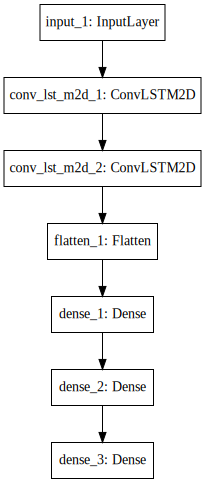

In [4]:
SVG(model_to_dot(arquitectura).create(prog='dot', format='svg'))

2. Redes convolucionales 3D para entrega la salida final.
>> 3D-CNN (CNN with 3D kernel -> to end)

Quizás cambiar a CCP

In [24]:
i1 = Input(shape=(T,W,H,C))#four dimensional array (3 without the channels of the image) 
#extraer caracteristicas
kernel_size = (3,3,3) # tercera es el largo temporal
f1 = Conv3D(16,kernel_size, strides=(1, 1, 1), padding='same', data_format=None, activation='relu')(i1)
f1 = MaxPool3D((2,2,2))(f1)
f2 = Conv3D(32,kernel_size, strides=(1, 1, 1), padding='same', data_format=None, activation='relu')(f1)
f2 = MaxPool3D((2,2,2))(f2)
#mas conv3D?
f3 = Conv3D(64,kernel_size, strides=(1, 1, 1), padding='same', data_format=None, activation='relu')(f2)
f3 = MaxPool3D((2,2,2))(f3)

#flatten
fla = Flatten()(f3)

#dense
f3 = Dense(512,activation='relu')(fla)
#f3 = Dense(256,activation='relu')(f3)

#clasificacion
f4 = Dense(1,activation='linear')(f3)

arquitectura = Model(i1,f4)
arquitectura.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 50, 40, 40, 3)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 50, 40, 40, 16)    1312      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 25, 20, 20, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 25, 20, 20, 32)    13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 12, 10, 10, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 12, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 6, 5, 5, 64)       0         
__________

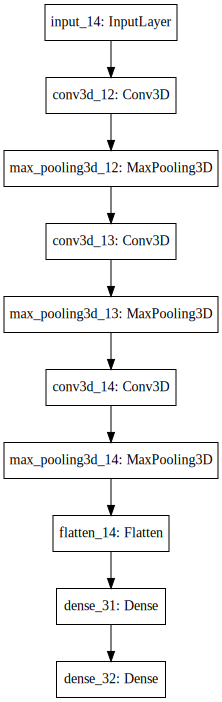

In [26]:
SVG(model_to_dot(arquitectura).create(prog='dot', format='svg'))


3. Redes convolucionales (2D o 3D) para extraer caract y luego alimentar una red recurrente con vectores 1D. (*two level network*)
>> CRNN (2D or 3D -Convs -> to RNN)

In [30]:
i1 = Input(shape=(T,W,H,C))#four dimensional array (3 without the channels of the image) 
#extraer caracteristicas
kernel_size = (3,3,3) # tercera es el largo temporal
f1 = TimeDistributed(Conv2D(16,(3,3),strides=(1, 1), padding='same', data_format=None, activation='relu'))(i1)
f1 = TimeDistributed(MaxPool2D((2,2)))(f1)
f2 = TimeDistributed(Conv2D(32,(3,3),strides=(1, 1), padding='same', data_format=None, activation='relu'))(f1)
f2 = TimeDistributed(MaxPool2D((2,2)))(f2)

#flatten
aux = f2.get_shape().as_list()
r1 = Reshape((aux[1],aux[2]*aux[3]*aux[4]))(f2)

#recurrencia
f2 = GRU(128,return_sequences=True)(r1)
#a uno
f3 = GRU(128,return_sequences=False)(f2)

#clasificacion
f4 = Dense(1,activation='linear')(f3)

arquitectura = Model(i1,f4)
arquitectura.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 50, 40, 40, 3)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 50, 40, 40, 16)    448       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 50, 20, 20, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 50, 20, 20, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 50, 10, 10, 32)    0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 50, 3200)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 128)           1278336   
__________

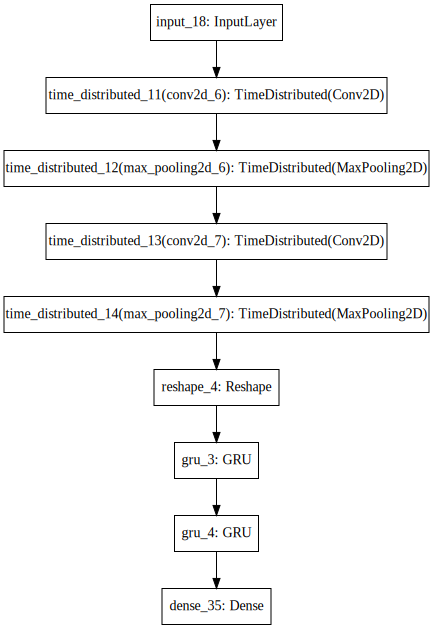

In [32]:
SVG(model_to_dot(arquitectura).create(prog='dot', format='svg'))

4. Redes convolucionales 2D a cada instante de tiempo, para entregar una salida final
>> 2D-CNN (CNN with 2D kernel -> to end)

5. MLP

In [33]:
i1 = Input(shape=(np.prod((T,W,H,C)),))#four dimensional array (3 without the channels of the image) 
#extraer caracteristicas
f1 = Dense(1024,activation='relu')(i1)
f1 = Dense(1024,activation='relu')(f1)

#clasificacion
f4 = Dense(1,activation='linear')(f1)

arquitectura = Model(i1,f4)
arquitectura.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 240000)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              245761024 
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 1025      
Total params: 246,811,649
Trainable params: 246,811,649
Non-trainable params: 0
_________________________________________________________________


### Prueba de concepto
---

In [16]:
arquitectura.compile(loss='mse',optimizer='rmsprop')
arquitectura.fit(data_t,label_t, batch_size=32,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 88s 88ms/step - loss: 12.6523
Epoch 2/10
1000/1000 [==============================] - 82s 82ms/step - loss: 0.3297
Epoch 3/10
  64/1000 [>.............................] - ETA: 1:15 - loss: 0.2506

KeyboardInterrupt: 

In [25]:
arquitectura.compile(loss='mse',optimizer='rmsprop')
arquitectura.fit(data_t,label_t, batch_size=32,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 10s 10ms/step - loss: 189.9605
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2969
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2831
Epoch 4/10
 160/1000 [===>..........................] - ETA: 6s - loss: 0.3409

KeyboardInterrupt: 

In [31]:
arquitectura.compile(loss='mse',optimizer='rmsprop')
arquitectura.fit(data_t,label_t, batch_size=32,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 16s 16ms/step - loss: 1.1541
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3614
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3983
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3218
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2602
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1645
Epoch 7/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0740
Epoch 8/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0608
Epoch 9/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0572
Epoch 10/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0468


### Posibles mejoras:
* BatchNormalization
* Dropout

### Comentarios:
Convolucional solo es mucho mas rápido  
Recurrente obtiene mejores scores pero es mas lento
